#   IAU Zadanie - Aktivita na cviceni

### Autori: Peter Brandajsky - 50%, Frederik Duvač - 50%

### Import vsetkych potrebnych kniznic

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import cv2

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
import wandb

In [2]:
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("PyTorch Version:", torch.__version__)
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

CUDA Available: True
CUDA Version: 11.8
PyTorch Version: 2.5.1+cu118
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Using cuda device


## 4.1.A

### EDA

#### Základne informácie o datasete

In [3]:
df = pd.read_csv('faces/train.csv')

# Zobrazenie informácií o datasete
print("Dataset info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
dtypes: object(2)
memory usage: 311.2+ KB
None

First 5 rows:
          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


#### Analýza distribúcie tried


Class distribution:
Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


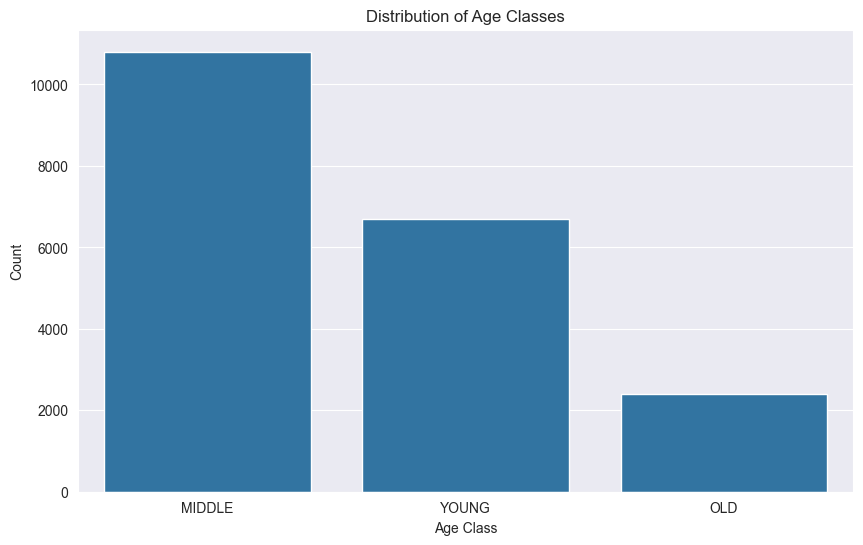

In [4]:
class_distribution = df['Class'].value_counts()
print("\nClass distribution:")
print(class_distribution)

# Vizualizácia distribúcie
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Distribution of Age Classes')
plt.ylabel('Count')
plt.xlabel('Age Class')
plt.show()

Vzhľadom na to, že máme nepomer tried, tak nastavíme pri trénovaní rozdielne váhy pre triedy aby sme optimalizovali učenie modelov.

#### Analýza obrazkov

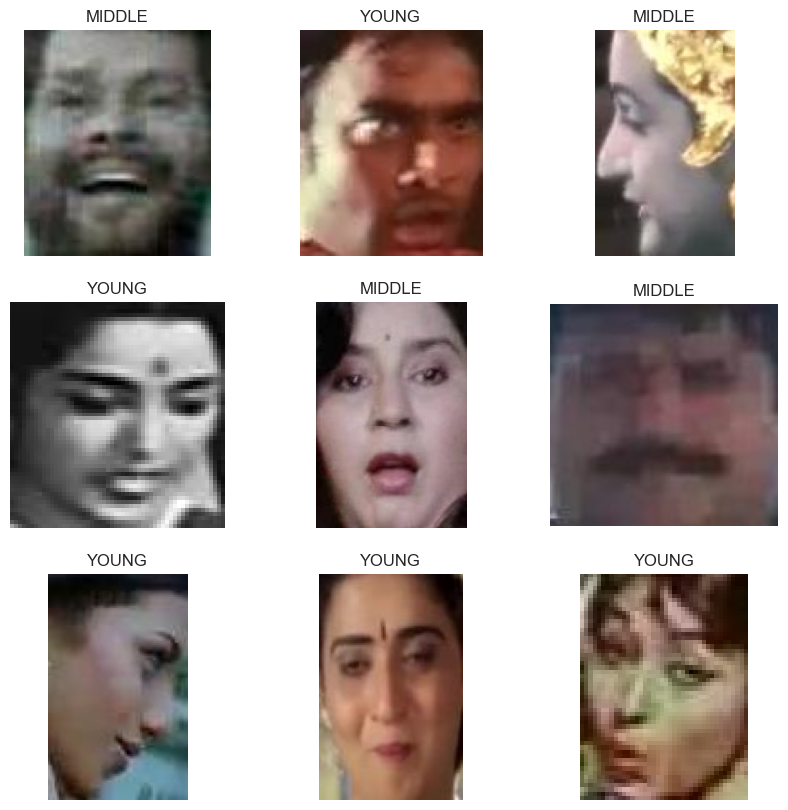

In [5]:
# Zobrazenie niekoľkých obrázkov
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join('faces/train', df['ID'][i])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
    plt.title(df['Class'][i])
    plt.axis('off')
plt.show()

### Preprocessing

#### V tomto kode
- Štandardizujeme veľkosť všetkých obrázkov
- Normalizujeme hodnoty pixelov do rozsahu 0-1
- Rozdelíme dataset na trénovaciu a validačnú časť
- Vytvoríme efektívny generátor dát pre trénovanie

In [6]:
# Definujeme konštanty pre preprocessing
TARGET_SIZE = (224, 224)  # štandardná veľkosť pre mnohé CNN architektúry
BATCH_SIZE = 32

# Enkódovanie labelov
label_encoder = LabelEncoder()
df['Class_encoded'] = label_encoder.fit_transform(df['Class'])

df.head(10)

,ID,Class,Class_encoded
0,377.jpg,MIDDLE,0
1,17814.jpg,YOUNG,2
2,21283.jpg,MIDDLE,0
3,16496.jpg,YOUNG,2
4,4487.jpg,MIDDLE,0
5,6283.jpg,MIDDLE,0
6,23495.jpg,YOUNG,2
7,7100.jpg,YOUNG,2
8,6028.jpg,YOUNG,2
9,22617.jpg,OLD,1


In [7]:
# Rozdelenie na tréning, validačnú a testovaciu množinu
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

Training set size: 13934
Validation set size: 2986
Test set size: 2986


#### Ako mozme vidiet, obrazky nie su rovnakej velkosti a nemaju rovnaku kvalitu, tak musime spravit nejaky preproccesing

In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]["ID"])
        img = cv2.imread(img_path)

        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Konverzia z BGR na RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label = self.dataframe.iloc[idx]["Class_encoded"]

        if self.transform:
            img = Image.fromarray(img)  # Pre transformácie musíme použiť PIL formát
            img = self.transform(img)

        return img, label


# Transformácie
train_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasety a DataLoadery
train_dataset = CustomDataset(train_df, root_dir="faces/train", transform=train_transforms)
val_dataset = CustomDataset(val_df, root_dir="faces/train", transform=val_test_transforms)
test_dataset = CustomDataset(test_df, root_dir="faces/train", transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

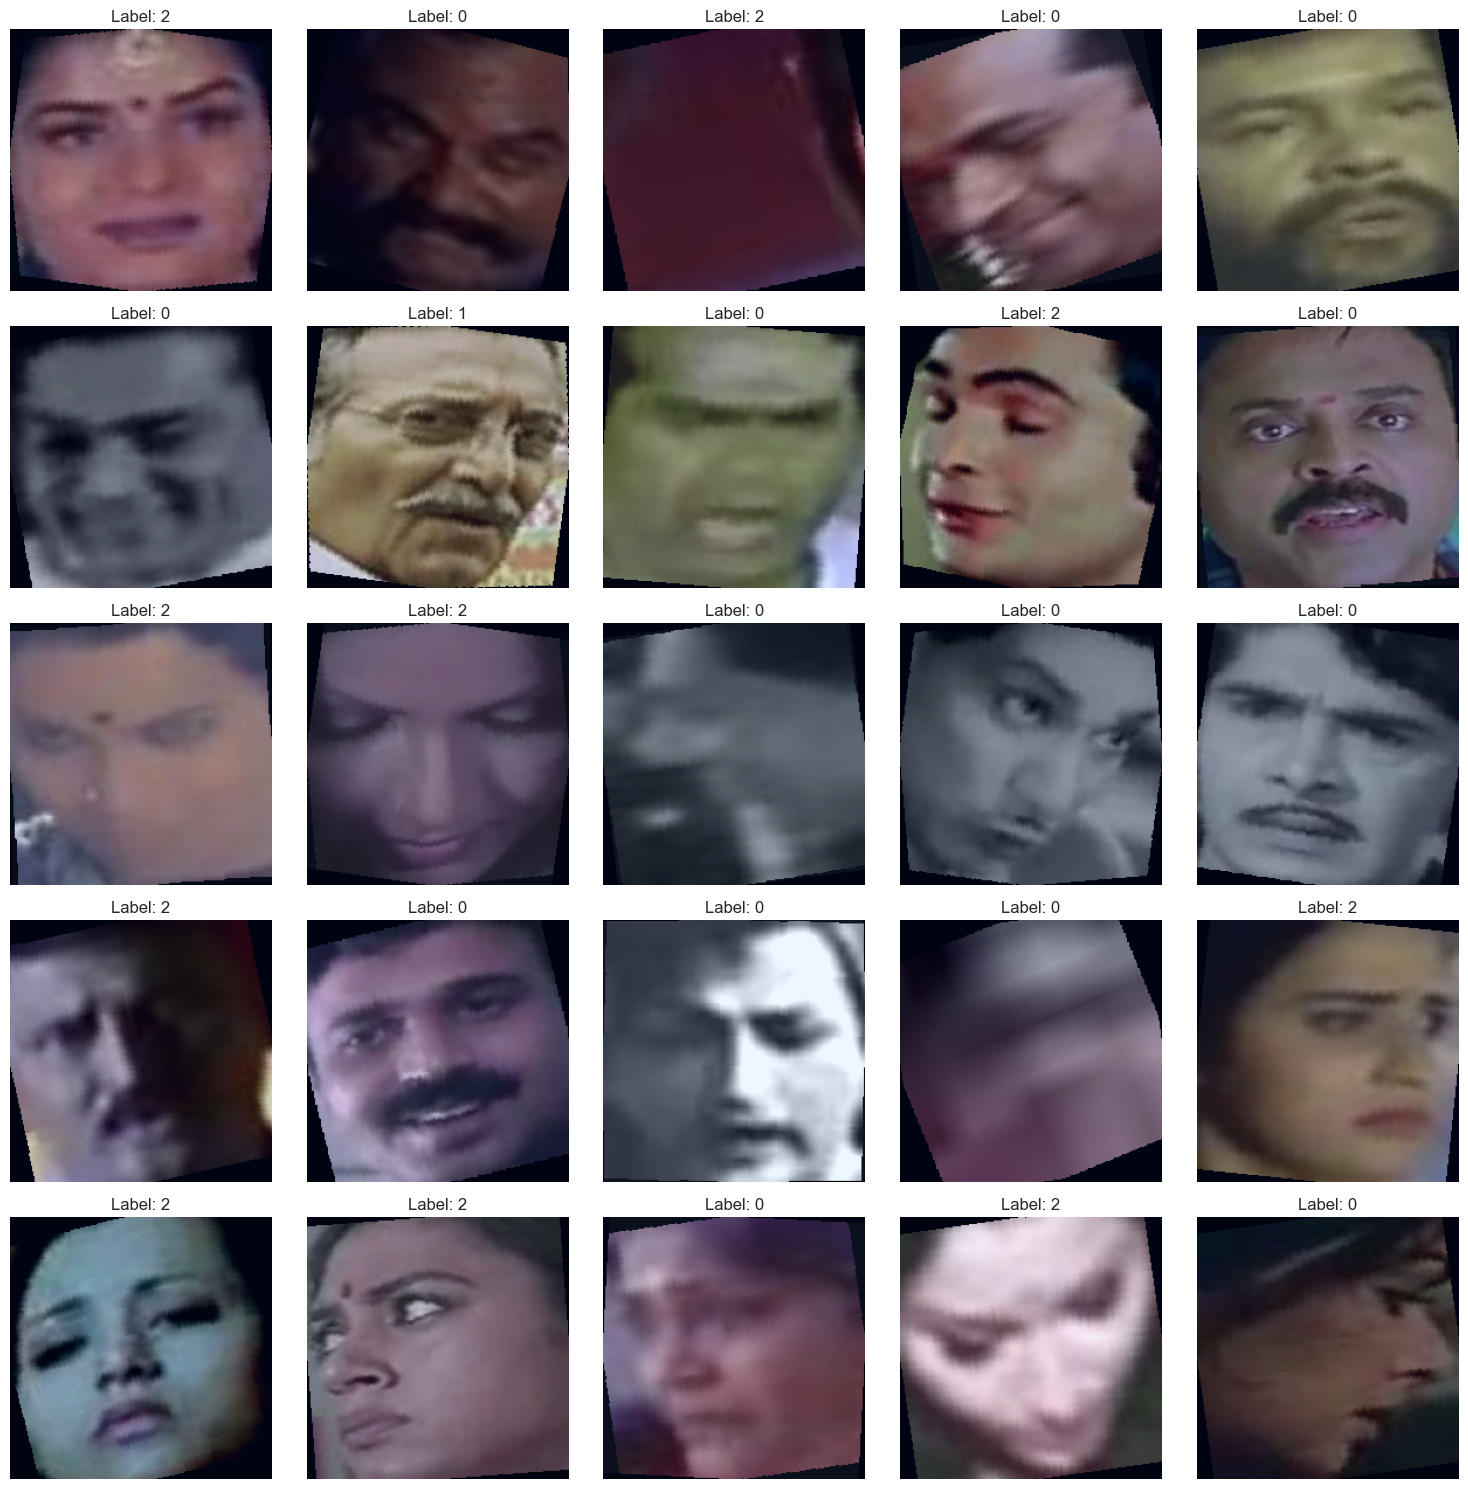

In [9]:
# Zobrazenie 5x5 => 25 augmentovaných obrázkov
indices = np.random.choice(len(train_dataset), size=25, replace=False)  # Randomly pick images

plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]  # Access directly from the dataset
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
    image = (image * 0.229 + 0.485)  # Denormalize
    image = np.clip(image, 0, 1)  # Ensure valid range

    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 4.1.B

### Pre Age Detection dataset navrhujeme použiť Konvolučnú neurónovú sieť (CNN), konkrétne architektúru založenú na ResNet50. Zdôvodnenie výberu:

#### Charakter dát:

- Pracujeme s obrázkami tvárí
- Máme 3 triedy (YOUNG, MIDDLE, OLD)
- Dataset obsahuje veľké množstvo vzoriek (26541 obrázkov)
- Obrázky majú rôznu kvalitu a veľkosť


#### Prečo CNN?

- CNN sú špecializované na spracovanie obrazových dát
- Automaticky sa učia hierarchiu príznakov - od jednoduchých hrán až po komplexné vzory
- Dokážu si poradiť s variabilitou v pozícii a veľkosti príznakov
- Sú robustné voči menším zmenám v obrázkoch


#### Prečo konkrétne ResNet50:

- Hlboká architektúra umožňuje zachytiť komplexné vzory starnutia
- Residuálne spojenia pomáhajú s problémom miznúceho gradientu
- Je predtrénovaná na ImageNet, čo umožňuje transfer learning
- Dokázala svoju efektivitu v podobných úlohách klasifikácie tvárí


#### Alternatívy, ktoré boli zvážené:

- VGG16/19: Jednoduchšia architektúra, ale náchylnejšia na preučenie
- MobileNet: Ľahšia architektúra, ale môže byť nedostatočne komplexná
- Custom CNN: Potrebovala by dlhší čas na tréning a ladenie

## 4.2.A

### Vytvorenie modelu ResNet50

In [10]:
class AgeDetectionModel(nn.Module):
    def __init__(self, num_classes=3):
        super(AgeDetectionModel, self).__init__()
        self.base_model = resnet50()
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.base_model.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


model = AgeDetectionModel(num_classes=len(label_encoder.classes_)).to(device)

In [11]:
# import torch.optim as optim
# from torch.nn.functional import cross_entropy
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
#
# # Váhy tried
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['Class']), y=train_df['Class'])
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
#
# # Stratová funkcia a optimizér
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
#
# # Tréningová funkcia
# def train_model(model, train_loader, val_loader, num_epochs=20):
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct, total = 0, 0
#
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#
#             # Forward + backward + optimize
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#
#             running_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()
#
#         train_acc = 100. * correct / total
#         print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")
#
#         # Validačný cyklus
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 val_loss += criterion(outputs, labels).item()
#                 _, predicted = outputs.max(1)
#                 val_total += labels.size(0)
#                 val_correct += predicted.eq(labels).sum().item()
#
#         val_acc = 100. * val_correct / val_total
#         print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
#
# train_model(model, train_loader, val_loader, num_epochs=20)


In [ ]:
# Nastavenie stratovej funkcie a optimizéra
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# wandb.init(project="age-detection-pytorch", config={
#     "epochs": 20,
#     "batch_size": 32,
#     "learning_rate": 1e-4,
#     "model": "ResNet50"
# })
# wandb.watch(model, log="all")

# Tréningová funkcia
def train_model(model, train_loader, val_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

        # Validácia
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Počas tréningu môžete logovať metriky:
        # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_acc": train_acc, "val_acc": val_acc})

    # wandb.finish()


train_model(model, train_loader, val_loader, num_epochs=20)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")


evaluate_model(model, test_loader)